In [188]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from pandas import DataFrame
import operator
from matplotlib import pyplot as plt
%matplotlib inline
from helper import Helper
import math

In [229]:
def ReadCSVFile(read_file_name):
    CrimeFile = open(read_file_name+".csv", 'r')
    CrimeList = list(csv.reader(CrimeFile,delimiter=',',quotechar='"'))
    CrimeFile.close()
    return CrimeList

def WriteCSVFile(data, filename): 
    with open(filename,"a") as f:
        w = csv.writer(f, delimiter=',', lineterminator='\n')
        w.writerows([data])

In [190]:
redshift_engine = Helper(cache_dir = "C:/Users/yyhuang2017/StudPortalsData/data/withKW").get_redshift_engine()

In [486]:
timePeriod = {"3 day test":['20170924', '20170927', '20170928', '20171001']
             ,"2 week":['20170913', '20170927', '20170928', '20171012'] 
             ,"1 week":['20170920', '20170927', '20170928', '20171005']  
             ,"2 month":['20170727', '20170927', '20170928', '20171128']} # 62, 62
period = "2 month"

In [487]:
query = """
        WITH actions AS (
            SELECT
            root_tstamp,
              root_id,
              action,
              action_id as study_id,
              cpm,
              target,amount,
              presence, level,
              DATEDIFF(day, '2017/09/27', root_tstamp) AS DateDiff,
               Case
                   WHEN location_id = '' THEN 0
                   WHEN location_id = action_id Then 0
                   ELSE CAST(location_id AS int)
                END as _position,
              action_type
            FROM atomic.com_studyportals_portallog_1
            join (select id, cpm, target,amount, presence, level from studyportals_sl.studies
                join (select _parent_id,target,amount from studyportals_sl.studies_tuition_fee_types) 
                as tui on _parent_id = id
            ) as st on id=action_id
            WHERE root_tstamp BETWEEN '{0}' and '{3}'
                AND action_type = 'study' 
                and (action = 'view' or (location_type = 'rslts' and ACTION = 'impr'))
        ), nuids AS (
            SELECT
              e.network_userid,
              e.collector_tstamp,
              a.*,
              e.page_urlfragment as url,
              Case
                WHEN e.page_urlfragment LIKE '%%kw-%%' THEN 1 else 0
              END as _has_keyword                      
            FROM actions AS a 
            JOIN atomic.events AS e ON a.root_id = e.event_id
            WHERE e.collector_tstamp BETWEEN '{0}' and '{3}'
                And br_family != 'Robot/Spider'
                AND ACTION in ('view','impr')
        )
        SELECT
           Case
               WHEN root_tstamp < '{1}' THEN 0 
               WHEN root_tstamp < '{2}' THEN 2 else 1
            END AS Time_Lable,
          DateDiff,
          guest_id,
          study_id,
          cpm,
          MAX(_has_keyword) as has_kw,
          MAX(_position) as POSITION,
          COUNT(*)/2 as clicks,
               Case
                   WHEN target = 'eea' THEN 0
                   WHEN target = 'international' Then 1
                   WHEN target = 'national' Then 2
                   ELSE 3
                END as _target,
                amount
        FROM nuids
          JOIN derived.guests_id_map AS m ON nuids.network_userid = m.network_userid
          where presence = 'public' and level ='master'
          GROUP BY guest_id, study_id, Time_Lable, cpm, _target,amount,DateDiff
          HAVING count(DISTINCT action) = 2""".format(timePeriod[period][0], timePeriod[period][1], timePeriod[period][2], timePeriod[period][3])

In [488]:
df = pd.read_sql(query,redshift_engine)

In [440]:
df.head()

,datediff,guest_id,study_id,cpm,has_kw,position,clicks,_target,amount
0,-62,935,375,2500.0,0,5,1,0,1906.0
1,-62,1074,17207,2500.0,1,3,1,1,15433.0
2,-62,1074,17207,2500.0,1,3,1,2,15433.0
3,-62,1374,31748,500.0,0,41,1,1,13500.0
4,-62,1722,74453,0.0,0,3,1,1,14500.0


In [441]:
df.dtypes

datediff      int64
guest_id      int64
study_id     object
cpm         float64
has_kw        int64
position      int64
clicks        int64
_target       int64
amount      float64
dtype: object

In [442]:
df.cpm = df.cpm.astype("int")
df.amount = df.amount.astype("int")

## Take out outliers from datasets + sorting of tuition (1 week and 2 week)

In [329]:
df.sort_values(['amount', 'position'], ascending=[0, 1]) \
.to_csv('Take out outliers '+str(outlier_threshold)+ ' sorting of tuition_' 
        + period + '.csv',index = False, sep=',', encoding='utf-8')

## comparative analysis of kw/non-kw, legacy/weighted, before/after rollout

In [450]:
First_x_pages = [1,2,3,4,5]
after_num = df["datediff"].max(axis=0) + 1
before_num =abs(df["datediff"].min(axis=0))

daily_weighted_clickposition_array = np.zeros((2 , len(First_x_pages) , after_num + before_num))
daily_weighted_click_array = np.zeros((2 , len(First_x_pages) , after_num + before_num))

daily_unique_clickposition_array = np.zeros((2 , len(First_x_pages) , after_num + before_num))
daily_unique_click_array = np.zeros((2 , len(First_x_pages) , after_num + before_num))

for kw in (0,1):
    page_data = df[(df.position > 1) & (df.position <= 50) & (df.has_kw == kw)& (df.datediff != 0)]
    """
    compute the x_th pages average positions for unique and weighted click
    """   
    for i in page_data.iterrows():
        #             daate = i[1].datediff
        #             page = math.ceil(i[1].position/10)
        #             position = i[1].position
        #             weighted_position = i[1].clicks * i[1].position 
        #             click = i[1].clicks         
        daily_weighted_clickposition_array[kw][math.ceil(i[1].position/10)-1][i[1].datediff] += i[1].clicks * i[1].position 
        daily_weighted_click_array[kw][math.ceil(i[1].position/10)-1][i[1].datediff] += i[1].clicks
        daily_unique_clickposition_array[kw][math.ceil(i[1].position/10)-1][i[1].datediff] += i[1].position
        daily_unique_click_array[kw][math.ceil(i[1].position/10)-1][i[1].datediff] += 1        

## Plot of average click position for different page over time

D:\anacon\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


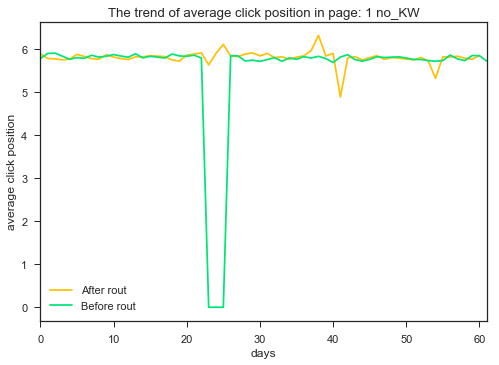

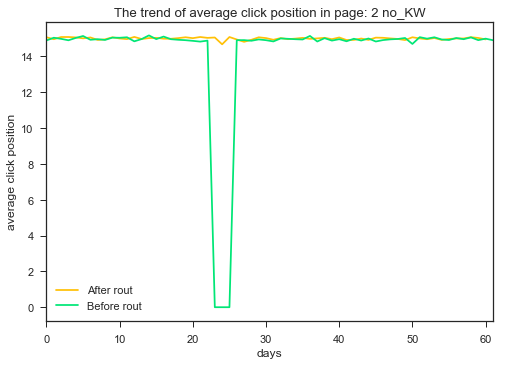

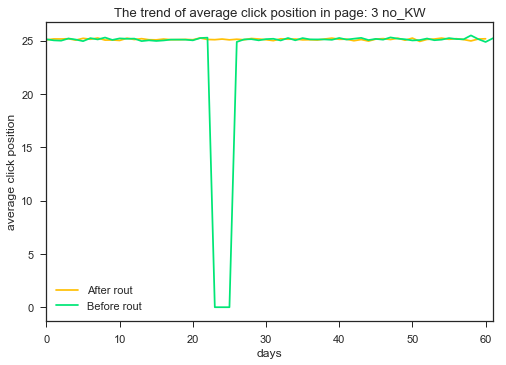

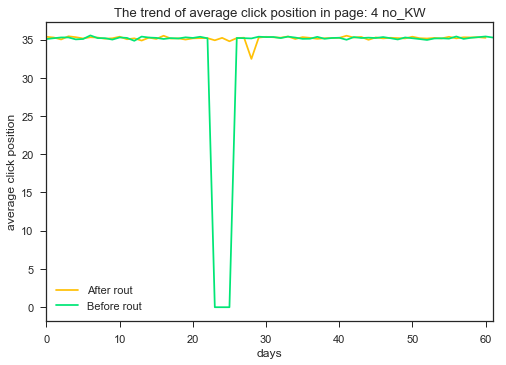

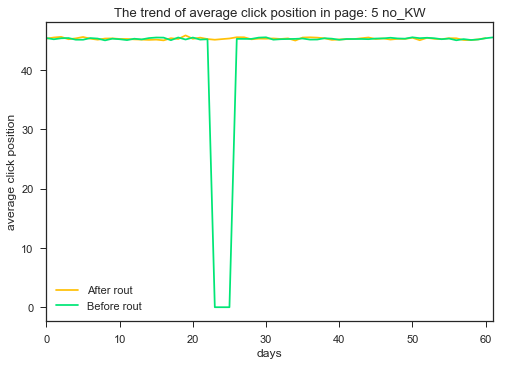

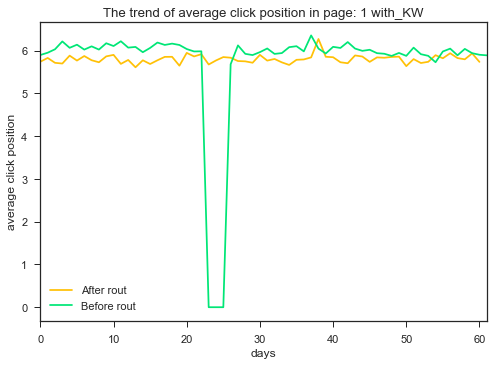

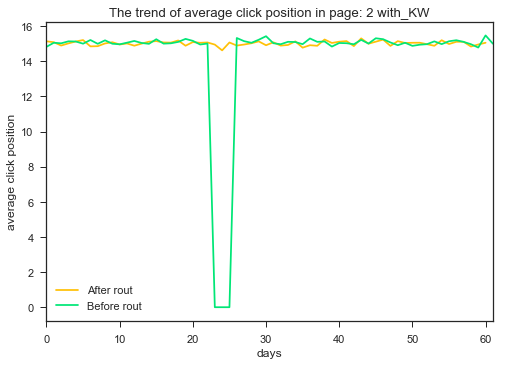

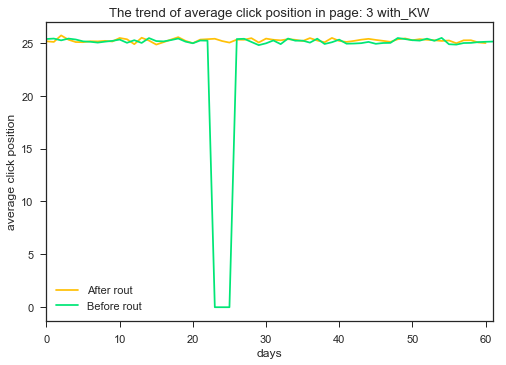

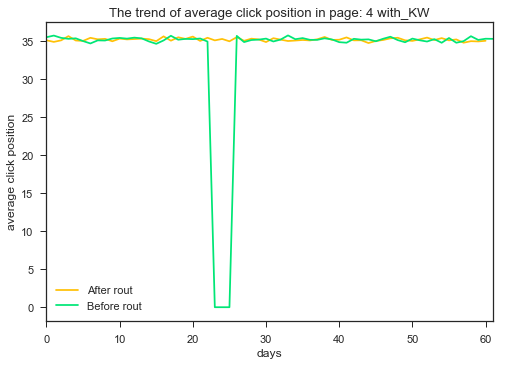

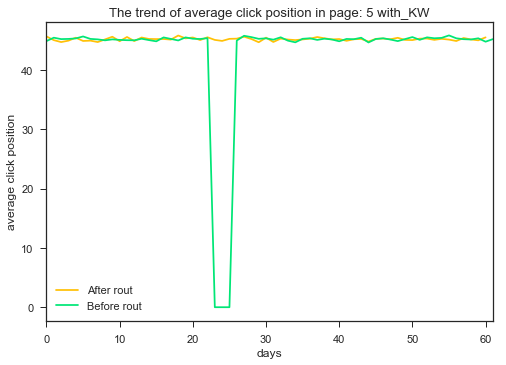

In [455]:
average_click_position_over_period = daily_weighted_clickposition_array / daily_weighted_click_array
average_click_position_over_period = np.nan_to_num(average_click_position_over_period)
kw_table = ["no_KW", "with_KW"]
_kw = 0
for i in average_click_position_over_period:
    _page = 1
    for j in i:
        ax_after = sns.tsplot(data=np.array(j[1:after_num]), color="#FFC107", legend =True, condition="After rout")
        ax_before = sns.tsplot(data=np.array(j[-before_num:][::-1]), color="#00E676",legend =True, condition="Before rout")
        plt.title('The trend of average click position in page: '
                  +str(_page)+" " + kw_table[_kw])
        plt.xlabel("days")
        plt.ylabel("average click position")
        plt.savefig(period + 'The trend of average click position in page '
                  +str(_page)+" " + kw_table[_kw]+'.png'
            , figsize=(6.5, 10)
            , dpi=100
            , label=str(kw_table[kw])+str(date_table[date]))
        plt.show()
        _page += 1
    _kw+=1

In [467]:
before_after_average_clicks = np.chararray((2,2,len(First_x_pages)),itemsize=12)
for kw in (0,1):
    for period in (0,1):
        cumu_daily_unique_clickposition = 0
        cumu_daily_unique_click = 0
        cumu_daily_weighted_clickposition = 0
        cumu_daily_weighted_click = 0
        for i in range(len(First_x_pages)):
            if period == 0:
                cumu_daily_unique_clickposition += daily_unique_clickposition_array[kw][i][-before_num:].sum()
                cumu_daily_unique_click += daily_unique_click_array[kw][i][-before_num:].sum()
                cumu_daily_weighted_clickposition += daily_weighted_clickposition_array[kw][i][-before_num:].sum()
                cumu_daily_weighted_click += daily_weighted_click_array[kw][i][-before_num:].sum()
            
                before_after_average_clicks[kw][period][i] = \
                    str(round(cumu_daily_unique_clickposition/cumu_daily_unique_click,2)) \
                    +"/"+str(round(cumu_daily_weighted_clickposition/cumu_daily_weighted_click,2))                         
            else:
                cumu_daily_unique_clickposition += daily_unique_clickposition_array[kw][i][:after_num].sum()
                cumu_daily_unique_click += daily_unique_click_array[kw][i][:after_num].sum()
                cumu_daily_weighted_clickposition += daily_weighted_clickposition_array[kw][i][:after_num].sum()
                cumu_daily_weighted_click += daily_weighted_click_array[kw][i][:after_num].sum()
                before_after_average_clicks[kw][period][i] = \
                    str(round(cumu_daily_unique_clickposition/cumu_daily_unique_click,2)) \
                    +"/"+str(round(cumu_daily_weighted_clickposition/cumu_daily_weighted_click,2)) 

## T-test before after rollout

In [515]:
kw_table = ["no_KW", "with_KW"]
position_thresd = range(10,51,10)
average_position_ttest = [[],[]]
for kw in (0,1):
    for i in position_thresd:
        prior_rout = df[(df.position>1)&(df.time_lable==0)&(df.has_kw==kw)&(df.position<=i)&(df.position>i-10)]["position"]
        after_rout = df[(df.position>1)&(df.time_lable==1)&(df.has_kw==kw)&(df.position<=i)&(df.position>i-10)]["position"]
        new_var = np.sqrt(((len(prior_rout) -1) * np.var(prior_rout)+(len(after_rout) -1) * np.var(after_rout)) \
                /(len(prior_rout)+len(after_rout) -2))
#         print (np.sum(prior_rout)/len(prior_rout))
#         print (np.sum(after_rout)/len(after_rout))
        new_ave = (np.sum(after_rout)/len(after_rout) - np.sum(prior_rout)/len(prior_rout)) \
        /(np.sqrt(1/len(prior_rout) + 1/len(after_rout)) * new_var)
#         print ("old variance: " + str(np.var(prior_rout)))
#         print ("new variance: " + str(np.var(after_rout)))
#         print ("standard deviation ratio: "+ str(np.var(after_rout)/np.var(prior_rout)) )
        if new_ave < -1.734:
            print (kw_table[kw] +"  "+str(i)+": reject  " + str(new_ave))
            average_position_ttest[kw].append("yes")
        else:
            print (kw_table[kw] +"  "+str(i)+": accepted" + str(new_ave)) 
            average_position_ttest[kw].append("no")
reshaped_average_position_ttest=[]
for i in zip(average_position_ttest[0],average_position_ttest[1]):
    reshaped_average_position_ttest.append(list(i))

no_KW  10: accepted4.8559336994
no_KW  20: accepted2.99350922333
no_KW  30: accepted0.683108065191
no_KW  40: accepted-0.740963895761
no_KW  50: accepted0.384741520769
with_KW  10: reject  -34.3237874798
with_KW  20: reject  -3.75285401733
with_KW  30: accepted1.68074423068
with_KW  40: accepted0.147022523837
with_KW  50: accepted0.0635240712633


## T-test w/wo keyword

In [505]:
position_thresd = range(10,51,10)
average_position_ttest_keyword = []
for i in position_thresd:
    without_kw = df[(df.position>1)&(df.time_lable==1)&(df.has_kw==0)&(df.position<=i)&(df.position>i-10)]["position"]
    with_kw = df[(df.position>1)&(df.time_lable==1)&(df.has_kw==1)&(df.position<=i)&(df.position>i-10)]["position"]
    new_var = np.sqrt(((len(without_kw) -1) * np.var(without_kw)+(len(with_kw) -1) * np.var(with_kw)) \
            /(len(without_kw)+len(with_kw) -2))
#         print (np.sum(prior_rout)/len(prior_rout))
#         print (np.sum(after_rout)/len(after_rout))
    new_ave = (np.sum(with_kw)/len(with_kw) - np.sum(without_kw)/len(without_kw)) \
    /(np.sqrt(1/len(without_kw) + 1/len(with_kw)) * new_var)
#         print ("old variance: " + str(np.var(prior_rout)))
#         print ("new variance: " + str(np.var(after_rout)))
#         print ("standard deviation ratio: "+ str(np.var(after_rout)/np.var(prior_rout)) )
    if new_ave < -1.734:
        print (str(i)+": reject  " + str(new_ave))
        average_position_ttest_keyword.append("yes")
    else:
        print (str(i)+": accepted" + str(new_ave)) 
        average_position_ttest_keyword.append("no")

10: reject  -18.2075071152
20: accepted6.42018331401
30: accepted5.64134032093
40: accepted-1.27882639656
50: accepted0.924843119059


In [516]:
reshaped_average_position_ttest = np.array(reshaped_average_position_ttest).reshape(2,5)
reshaped_average_position_ttest

array([['no', 'yes', 'no', 'yes', 'no'],
       ['no', 'no', 'no', 'no', 'no']], 
      dtype='<U3')

In [513]:
print (average_position_ttest_keyword)
print (reshaped_average_position_ttest)
print (before_after_average_clicks)

['yes', 'no', 'no', 'no', 'no']
[['no' 'yes' 'no' 'yes' 'no']
 ['no' 'no' 'no' 'no' 'no']]
[[[b'5.59/5.81' b'8.07/8.06' b'10.06/9.88' b'11.73/11.38' b'13.19/12.67']
  [b'5.61/5.81' b'8.08/8.04' b'10.1/9.85' b'11.82/11.4' b'13.31/12.71']]

 [[b'5.77/6.02' b'8.42/8.44' b'10.66/10.47' b'12.53/12.12' b'14.13/13.53']
  [b'5.52/5.81' b'7.94/8.02' b'9.99/9.91' b'11.68/11.41' b'13.15/12.74']]]


In [526]:
"""
Interleaving two lists
"""
writing_list = []
for i in range(len(before_after_average_clicks)): 
    k = i ^ 1
    writing_list.append([val for pair in zip(before_after_average_clicks[i][0]
                                ,before_after_average_clicks[i][1]
                                ,reshaped_average_position_ttest[k]) for val in pair])

In [527]:
significant_list = []
for i in average_position_ttest_keyword: 
    significant_list.extend(["",i,""])

In [528]:
significant_list

['', 'yes', '', '', 'no', '', '', 'no', '', '', 'no', '', '', 'no', '']

## average click position report

In [529]:
page_report = DataFrame({"page":["Search Result Page 1 Average click position","",""
                   ,"Search Result Page 2 Average click position","",""
                    ,"Search Result Page 3 Average click position","",""    
                   ,"Search Result Page 4 Average click position","",""
                   ,"Search Result Page 5 Average click position","",""]
           ,"time":["2 month before roll-out (wed-tue)","2 month after roll-out (thu-wed)",""
                   ,"2 month before roll-out (wed-tue)","2 month after roll-out (thu-wed)",""
                   ,"2 month before roll-out (wed-tue)","2 month after roll-out (thu-wed)",""
                   ,"2 month before roll-out (wed-tue)","2 month after roll-out (thu-wed)",""
                   ,"2 month before roll-out (wed-tue)","2 month after roll-out (thu-wed)",""]
           ,"for searches that include a keyword (includes kw-)":writing_list[1]
            ,"for searches that don't include a keyword (excludes kw-)":writing_list[0]
            ,"Significant difference?":significant_list})
page_report.to_csv("average_click_" + period + "_report.csv",index = False, sep=',', encoding='utf-8')

---

## revenue

In [366]:
_title = ["for searches that don't include a keyword (excludes kw-)","for searches that include a keyword (includes kw-)"]
total_list = []
for kw in (0,1):
    writing_list = []
    writing_list.append(_title[kw])
    """
    unique guest number
    """    
    total_guest_num_before = len(df[(df.time_lable == 0)& (df.has_kw == kw)]["guest_id"].unique())
    total_guest_num_after = len(df[(df.time_lable == 1)& (df.has_kw == kw)]["guest_id"].unique())
    
    writing_list.append(total_guest_num_before)
    writing_list.append(total_guest_num_after)
    writing_list.append(str(round(100*(total_guest_num_after - total_guest_num_before)/total_guest_num_before,2)) + "%")
    
    """
    total click number
    """
    bf_prem = df[(df.time_lable == 0) & (df.has_kw == kw) &(df.cpm < 5000)&(df.cpm > 0)]
    bf_super_prem = df[(df.time_lable == 0) & (df.has_kw == kw) &(df.cpm == 5000)]
    af_prem = df[(df.time_lable == 1) & (df.has_kw == kw) &(df.cpm < 5000)&(df.cpm > 0)]
    af_super_prem = df[(df.time_lable == 1) & (df.has_kw == kw) &(df.cpm == 5000)]
    
    total_click_num_before = len(df[(df.time_lable == 0) & (df.has_kw == kw)]["clicks"])
    total_click_num_after = len(df[(df.time_lable == 1) & (df.has_kw == kw)]["clicks"])

    writing_list.extend([total_click_num_before, total_click_num_after])
    writing_list.append(str(round(100*(total_click_num_after - total_click_num_before)/total_click_num_before,2)) + "%")
    """
    average click per guest
    """
    ave_click_before = total_click_num_before/total_guest_num_before
    ave_click_after = total_click_num_after/total_guest_num_after
    writing_list.append(ave_click_before)
    writing_list.append(ave_click_after)
    writing_list.append(str(round(100*(ave_click_after - ave_click_before)/ave_click_before,2)) + "%")

    """
    premium revenue and change in %
    """
    writing_list.extend([str(len(bf_prem) * 4) +" ("+str(len(bf_prem))+" clicks)"
                         , str(len(af_prem) * 4) +" ("+str(len(af_prem))+" clicks)"])
    writing_list.append(str(round(100*(len(af_prem) - len(bf_prem))/len(bf_prem),2)) + "%")
    """
    super premium revenue and change in %
    """
    writing_list.extend([str(len(bf_super_prem) * 5.6)+ " (" +str(len(bf_super_prem))+" clicks)"
                        ,str(len(af_super_prem) * 5.6) + " ("+str(len(af_super_prem))+" clicks)"])
    writing_list.append(str(round(100*(len(af_super_prem) - len(bf_super_prem))/len(bf_super_prem),2)) + "%")
    """
    total revenue and change in %
    """    
    bf_total_revenue = len(bf_super_prem)*5.6 + len(bf_prem) * 4
    af_total_revenue = len(af_super_prem)*5.6 + len(af_prem) * 4
    
    writing_list.append(str(bf_total_revenue))
    writing_list.append(str(af_total_revenue))
    writing_list.append(str(round(100*(af_total_revenue - bf_total_revenue)/bf_total_revenue,2)) + "%")
    """
    average revenue per user
    """
    bf_ave_revenue_user = bf_total_revenue/total_guest_num_before
    af_ave_revenue_user = af_total_revenue/total_guest_num_after
    writing_list.append(str(bf_ave_revenue_user))
    writing_list.append(str(af_ave_revenue_user))
    writing_list.append(str(round(100*(af_ave_revenue_user - bf_ave_revenue_user)/bf_ave_revenue_user,2)) + "%")
    total_list.append(writing_list)

In [367]:
header = [""
          , period + " before roll-out (wed-tue)", period + " after roll-out (thu-wed)", "total user" 
          , period + " before roll-out (wed-tue)", period + " after roll-out (thu-wed)", "total click"
          , period + " before roll-out (wed-tue)", period + " after roll-out (thu-wed)", "average click/user"
          , period + " before roll-out (wed-tue)", period + " after roll-out (thu-wed)", "premium revenue"
          , period + " before roll-out (wed-tue)", period + " after roll-out (thu-wed)", "super premium revenue"
          , period + " before roll-out (wed-tue)", period + " after roll-out (thu-wed)", "total revenue" 
          , period + " before roll-out (wed-tue)", period + " after roll-out (thu-wed)", "average revenue/user"]

## revenue report

In [368]:
DataFrame({"header":header, "non_kw":total_list[0], "kw":total_list[1]})\
.to_csv("revenue_" + period + "_report.csv",index = False, sep=',', encoding='utf-8')

# study fairness distribution and plots

date: 0 , kw: 0
date: 0 , kw: 1
date: 1 , kw: 0
date: 1 , kw: 1


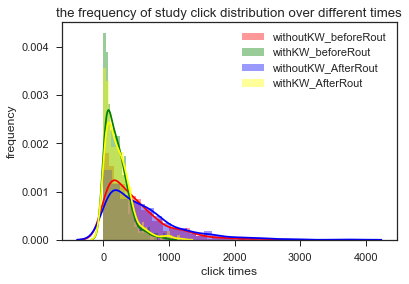

In [370]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

kw_table = ["withoutKW", "withKW"]
date_table =  ["beforeRout", "AfterRout"]
colors=[["red", "green"], ["blue","yellow"]]

for date in (0,1):
    for kw in (0,1):
        data = df[(df.time_lable == date) & (df.has_kw == kw)]['study_id']
        premium_clicks = len(data)
        print ("date: " + str(date) + " , kw: " + str(kw))
        study_cnt = Counter()
        for i in data:
            study_cnt[i] += 1
        Frequency_cnt = Counter()
        for i in study_cnt.values():
            Frequency_cnt[i] += 1
        DataFrame({"study_id": [i for i in study_cnt.keys()]
                  ,"freq": [j for j in study_cnt.values()]}).to_csv(kw_table[kw] + '_' + date_table[date] 
                                                                    + '_'+period+'_studyHisto.csv', index = False, sep=',', encoding='utf-8')
        DataFrame({"freq": [i for i in Frequency_cnt.keys()]
                  ,"freq of freq": [j for j in Frequency_cnt.values()]}).to_csv(kw_table[kw] + '_' + date_table[date] + '_'
                                                                                +period+'_freqHisto.csv',index = False
                                                                                , sep=',', encoding='utf-8')
        default = DataFrame({"freq": [i for i in Frequency_cnt.keys()],"freq of freq": [j for j in Frequency_cnt.values()]})["freq"]
        sns.distplot((default)
                     ,color=colors[date][kw]
                     , kde=True, hist=True
                     , bins = 30
                     , label=(str(kw_table[kw])+"_"+str(date_table[date]))
                     , norm_hist = True )
        plt.legend()
# Set title
plt.title('the frequency of study click distribution over different times')
# Set x-axis label
plt.xlabel("click times")
# Set y-axis label
plt.ylabel("frequency")
plt.savefig(period + '_the frequency of study click distribution over different times.png'
            , figsize=(6.5, 10)
            , dpi=100
            , label=str(kw_table[kw])+str(date_table[date]))
plt.show()
           


## average click position distribution for 5 premiumness 

beforeRout withoutKW


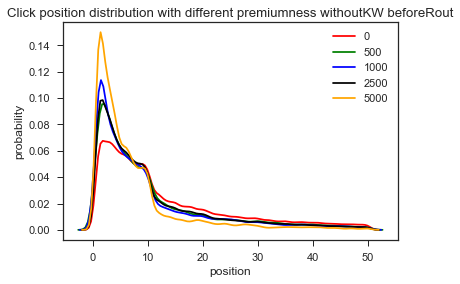

beforeRout withKW


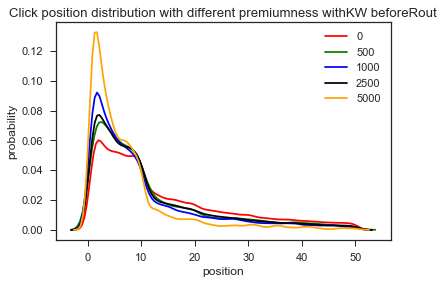

AfterRout withoutKW


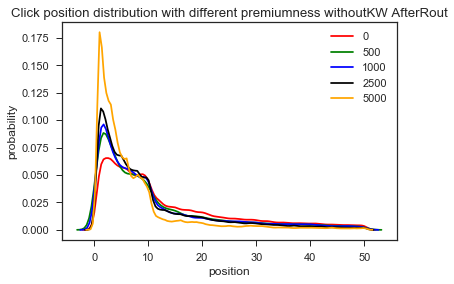

AfterRout withKW


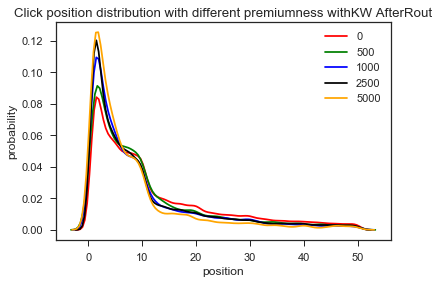

In [371]:
bin_para = 20
position_thresd = 50
date_table =  ["beforeRout", "AfterRout"]
cpm_val = [0,500,1000,2500,5000]
colors=["red", "green", "blue","black","orange"]
for date in (0,1):
    for kw in (0,1):
        print (date_table[date]+" "+kw_table[kw])
        for val in cpm_val:
            data = df[(df.time_lable == date) & (df.has_kw == kw) & (df.position <=position_thresd)& (df.cpm ==val)]["position"]


            sns.distplot((data)
                         ,color=colors[cpm_val.index(val)]
                         , kde=True, hist=False
                         , bins = bin_para
                         , label=val
                         , norm_hist = True)
            plt.legend()
        # Set title
        plt.title('Click position distribution with different premiumness '+kw_table[kw] + ' ' + date_table[date])
        # Set x-axis label
        plt.xlabel("position")
        # Set y-axis label
        plt.ylabel("probability")
        plt.savefig(kw_table[kw] + '_' + date_table[date]  + '_' + period + '_avg_position_premiumness.png'
                , figsize=(6.5, 10)
                , dpi=100
                , label=str(date_table[date]))
            
        plt.show()        

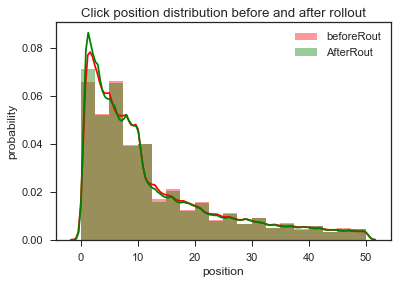

In [372]:
colors=["red", "green"]
bin_para = 20
position_thresd = 50
for date in (0,1):
    data = df[(df.time_lable == date) & (df.position <=position_thresd)]["position"]
    sns.distplot((data)
                 ,color=colors[date]
                 , kde=True, hist=True
                 , bins = bin_para
                 , label=date_table[date]
                 , norm_hist = True)
    plt.legend()
# Set title
plt.title('Click position distribution before and after rollout')
# Set x-axis label
plt.xlabel("position")
# Set y-axis label
plt.ylabel("probability")

plt.savefig(period + '_click_position_distribution_after_before_rollout.png'
        , figsize=(6.5, 10)
        , dpi=100
        , label=str(date_table[date]))
plt.show()

## Study distribution (fairness)

In [422]:
df_af_KW_rollout = pd.read_csv ('2 month analysis//withKW_AfterRout_2 month_studyHisto.csv')

df_af_KW_rollout = pd.read_csv('2 month analysis//withKW_beforeRout_2 month_studyHisto.csv')

In [423]:
KW_rollout_studyDist_dict = dict() 
for i in range(len(df_af_KW_rollout)):
    KW_rollout_studyDist_dict.update({df_af_KW_rollout["study_id"][i]: df_af_KW_rollout["freq"][i]}) 
for i in range(len(df_bf_KW_rollout)):
    if df_bf_KW_rollout["study_id"][i] in KW_rollout_studyDist_dict:
        KW_rollout_studyDist_dict[df_bf_KW_rollout["study_id"][i]] = KW_rollout_studyDist_dict[df_bf_KW_rollout["study_id"][i]] - df_bf_KW_rollout["freq"][i]
    else:
        KW_rollout_studyDist_dict.update({df_bf_KW_rollout["study_id"][i]: -df_bf_KW_rollout["freq"][i]}) 

In [424]:
redshift_engine = Helper(cache_dir = "C:/Users/yyhuang2017/StudPortalsData/data/withKW").get_redshift_engine()
query = """select id,cpm from studyportals_sl.studies"""
studyId_premium_df = pd.read_sql(query,redshift_engine)
studyId_premium_df.cpm = studyId_premium_df.cpm.astype("int")
studyId_premium_df.id = studyId_premium_df.id.astype("int")

In [425]:
studyId_premium_dict = dict()
for i in range(len(studyId_premium_df)):
    studyId_premium_dict.update({studyId_premium_df["id"][i]: studyId_premium_df["cpm"][i]}) 

In [426]:
clickChange_list = list(KW_rollout_studyDist_dict.values())
clickSum = np.sum(clickChange_list)
clickLen = len(clickChange_list)
clickAve = clickSum/clickLen
clickStd = np.std(clickChange_list)
outlierUpperBound = clickAve + 1.96 * clickStd
outlierLowerBound = clickAve - 1.96 * clickStd

Outlier_list = list()
StudyId = list()
Changes = list()
premiumness = list()
for i,j in KW_rollout_studyDist_dict.items():
    StudyId.append(i)
    Changes.append(j)
    if j > outlierUpperBound :
        Outlier_list.append("positive outlier")
        premiumness.append(studyId_premium_dict[i])
    elif j < outlierLowerBound:
        Outlier_list.append("negative outlier")
        premiumness.append(studyId_premium_dict[i])
    else:
        Outlier_list.append("within confidence interval")
        premiumness.append(studyId_premium_dict[i])
chart_df = DataFrame({"Study Id": StudyId, "Changes": Changes ,"IsOutlier": Outlier_list, "premiumness": premiumness})

## Revenue change from studies beyond the confidence interval 

In [428]:
positive_outlier_df = chart_df[chart_df["IsOutlier"]=="positive outlier"]
upper_revenue_influence = np.sum(positive_outlier_df[(chart_df.premiumness < 5000) & (chart_df.premiumness > 0)].Changes * 4) \
                        + np.sum(positive_outlier_df[chart_df.premiumness == 5000].Changes * 5.6) 
negative_outlier_df = chart_df[chart_df["IsOutlier"]=="negative outlier"]
lower_revenue_influence = np.sum(negative_outlier_df[(chart_df.premiumness < 5000) & (chart_df.premiumness > 0)].Changes * 4) \
                        + np.sum(negative_outlier_df[chart_df.premiumness == 5000].Changes * 5.6) 

D:\anacon\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
D:\anacon\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [430]:
chart_df.to_csv('the outlier of click change over studies withKW.csv'
    , index=False
    , sep=','
    , encoding='utf-8')

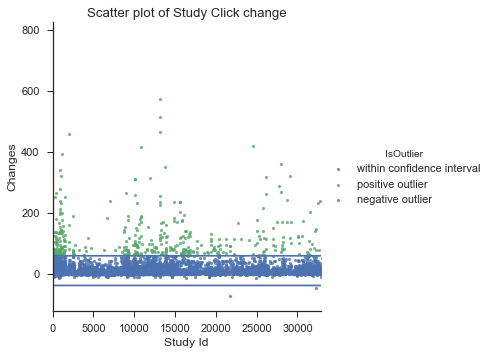

In [432]:
# Set style of scatterplot
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# Create scatterplot of dataframe
sns.lmplot("Study Id", # Horizontal axis
           "Changes", # Vertical axis
           data=chart_df, # Data source
           fit_reg=False, # Don't fix a regression line
           hue="IsOutlier", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 10}) # S marker size

ax = sns.tsplot(data=outlierUpperBound*np.ones(len(StudyId)), color="b")
ax = sns.tsplot(data=outlierLowerBound*np.ones(len(StudyId)), color="b")
# Set title
plt.title('Scatter plot of Study Click change')

# Set x-axis label
plt.xlabel("Study Id")

# Set y-axis label
plt.ylabel("Changes")

plt.savefig(period + '_Scatter plot of Study Click change with kw.png'
            , figsize=(6.5, 10)
            , dpi=100
            , label=str(kw_table[kw])+str(date_table[date]))

In [15]:
a=[2,0,1,3]
i = 0
j = 1
k = 2

In [16]:
a[k],a[i],a[j] =a[i],a[j],a[k]
a

[0, 1, 2, 3]

In [14]:
a

[2, 0, 2, 2, 2, 1, 3, 3, 3, 6]

In [18]:
from collections import deque

In [21]:
items = deque([1, 2])
items.append(3) # deque == [1, 2, 3]


In [22]:
items[:2]
#.rotate(1) # The deque is now: [3, 1, 2]


TypeError: sequence index must be integer, not 'slice'

In [26]:
a = [10,15]
b = [34,56,42]
[a[0]]+b[1:3]

[10, 56, 42]

In [27]:
(5+6)//2

5